# Modelo ML para tasas m (edad × período)
Replicamos el flujo del notebook APC/Lee-Carter: lectura, split 1979–2018 (train) y 2019–2023 (validación), entrenamiento, métricas y gráficos. Usamos Gradient Boosting sobre log(m).

In [1]:
# Imports y configuración
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Rutas (idénticas al resto de notebooks)
PROJ_ROOT = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
DATA_PATH = os.path.join(PROJ_ROOT, "data", "processed", "mortalidad")
BASE_OUT = os.path.join(PROJ_ROOT, "modelos", "outputs")
NOTEBOOK_NAME = os.path.splitext(os.path.basename(os.environ.get("NOTEBOOK_BASENAME", "b_05_ml.ipynb")))[0]
OUT_DIR = os.path.join(BASE_OUT, "output", NOTEBOOK_NAME)
os.makedirs(OUT_DIR, exist_ok=True)

print(f"Usando datos desde: {DATA_PATH}")
print(f"Guardando resultados en: {OUT_DIR}")

pd.set_option('display.width', 140)
pd.set_option('display.max_columns', 50)
sns.set_context("talk")
plt.rcParams["figure.figsize"] = (10, 5)

Usando datos desde: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/data/processed/mortalidad
Guardando resultados en: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/b_05_ml


In [2]:
# Estilo unificado para gráficos (viz.style)
import sys, os
for candidate in ("src", "../src", "../../src", "../../../src"):
    p = os.path.abspath(candidate)
    if os.path.isdir(p) and p not in sys.path:
        sys.path.append(p)
try:
    import importlib, viz.style as _vstyle
    importlib.reload(_vstyle)
except Exception:
    pass
from viz.style import apply_matplotlib_style

apply_matplotlib_style(
    n_colors=7,
    base_font_size=11,
    seaborn_style="white",
    background="white",
    transparent=False,
)
print("Estilo aplicado.")

Estilo aplicado.


In [3]:
# Carga de datos y construcción de matriz edad×año
file_long = os.path.join(DATA_PATH, "tasas_mortalidad_gret_per.csv")
df_long = pd.read_csv(file_long)
df_long = df_long.rename(columns={"ano": "year", "gr_et": "age"})

# Tasa por persona (m) a partir de tasa_x100k
EPS = 1e-12
df_long_m = df_long[["year", "age", "tasa_x100k"]].copy()
df_long_m["m"] = df_long_m["tasa_x100k"] / 1e5
df_long_m["m"] = df_long_m["m"].clip(lower=EPS)

# Pivot edad×año, y orden por edad y año
mat = df_long_m.pivot(index="age", columns="year", values="m").sort_index()
ages = mat.index.values
all_periods = mat.columns.values
n_age = len(ages)
print(mat.shape, mat.index.min(), mat.index.max(), all_periods.min(), all_periods.max())
mat.head()

(17, 45) 1 17 1979 2023


year,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
age,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.000049,0.000042,0.000044,0.000039,0.000028,0.000022,0.000024,0.000018,0.000015,0.000014,0.000011,0.000010,0.000009,0.000009,0.000008,0.000006,0.000006,0.000005,0.000004,0.000006,0.000006,0.000006,0.000005,8.499482e-06,0.000007,6.534167e-06,0.000006,7.710106e-06,0.000005,8.390200e-06,0.000006,0.000003,3.653421e-06,3.153650e-06,5.815563e-06,2.921598e-06,2.398540e-06,2.666065e-06,2.392366e-06,3.153282e-06,3.668709e-06,0.000002,3.129253e-06,4.469724e-06,0.000003
2,0.000012,0.000011,0.000013,0.000010,0.000006,0.000009,0.000009,0.000007,0.000007,0.000005,0.000003,0.000004,0.000004,0.000002,0.000004,0.000003,0.000002,0.000002,0.000002,0.000002,0.000001,0.000002,0.000003,2.798329e-06,0.000002,7.009429e-07,0.000003,1.657103e-06,0.000002,1.449898e-06,0.000002,0.000002,1.249956e-06,2.527166e-07,5.106775e-07,7.732517e-07,1.559143e-06,5.224731e-07,2.617115e-07,4.921904e-07,7.389123e-07,0.000001,4.932269e-07,2.482730e-07,0.000002
3,0.000009,0.000006,0.000010,0.000009,0.000006,0.000007,0.000004,0.000005,0.000003,0.000005,0.000002,0.000004,0.000003,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000003,0.000002,0.000003,7.387396e-07,0.000003,9.613654e-07,0.000002,9.458863e-07,0.000002,9.408289e-07,0.000002,0.000002,7.141590e-07,4.802836e-07,4.853084e-07,9.816835e-07,7.445327e-07,1.002307e-06,1.515173e-06,1.401163e-06,1.396822e-06,0.000001,9.338040e-07,1.178135e-06,0.000001
4,0.000015,0.000013,0.000017,0.000014,0.000012,0.000014,0.000015,0.000008,0.000011,0.000011,0.000008,0.000006,0.000008,0.000008,0.000007,0.000007,0.000006,0.000009,0.000005,0.000006,0.000006,0.000006,0.000006,7.621104e-06,0.000005,3.371316e-06,0.000003,4.305802e-06,0.000005,4.929344e-06,0.000003,0.000003,3.584486e-06,2.853929e-06,3.324185e-06,2.852953e-06,2.863328e-06,4.075270e-06,2.891899e-06,3.997186e-06,3.474033e-06,0.000004,4.770033e-06,5.670935e-06,0.000005
5,0.000034,0.000038,0.000032,0.000031,0.000027,0.000026,0.000019,0.000019,0.000023,0.000018,0.000015,0.000014,0.000014,0.000014,0.000013,0.000016,0.000013,0.000012,0.000011,0.000012,0.000012,0.000011,0.000012,1.439396e-05,0.000011,1.262662e-05,0.000008,8.655184e-06,0.000009,1.042390e-05,0.000010,0.000005,7.747502e-06,6.875696e-06,5.778954e-06,8.438986e-06,5.401696e-06,6.803984e-06,5.055585e-06,7.018536e-06,7.070214e-06,0.000007,1.016314e-05,1.279901e-05,0.000011


In [4]:
# Construcción del dataset para ML (long format desde la matriz)
df_ml = (mat.reset_index()
           .melt(id_vars="age", var_name="year", value_name="m")
           .dropna())
df_ml["year"] = df_ml["year"].astype(int)
df_ml["age"] = df_ml["age"].astype(int)
df_ml["cohort"] = df_ml["year"] - df_ml["age"]
df_ml["log_m"] = np.log(df_ml["m"].clip(lower=1e-12))
print(df_ml.head())
print(df_ml.groupby("year").size().head())

   age  year         m  cohort      log_m
0    1  1979  0.000049    1978  -9.923203
1    2  1979  0.000012    1977 -11.324133
2    3  1979  0.000009    1976 -11.606873
3    4  1979  0.000015    1975 -11.094065
4    5  1979  0.000034    1974 -10.301822
year
1979    17
1980    17
1981    17
1982    17
1983    17
dtype: int64


In [5]:
# Split temporal: train (1979–2018), valid (2019–2023)
train_mask = (df_ml["year"] >= 1979) & (df_ml["year"] <= 2018)
val_mask = (df_ml["year"] >= 2019) & (df_ml["year"] <= 2023)

train_df = df_ml.loc[train_mask].copy()
val_df = df_ml.loc[val_mask].copy()

features = ["age", "year", "cohort"]
X_train = train_df[features].values
y_train = train_df["log_m"].values
X_val = val_df[features].values
y_val = val_df["log_m"].values

len_train, len_val = len(train_df), len(val_df)
print(f"Rows train: {len_train} | Rows val: {len_val}")

Rows train: 680 | Rows val: 85


In [6]:
train_df.head()

,age,year,m,cohort,log_m
0,1,1979,0.000049,1978,-9.923203
1,2,1979,0.000012,1977,-11.324133
2,3,1979,0.000009,1976,-11.606873
3,4,1979,0.000015,1975,-11.094065
4,5,1979,0.000034,1974,-10.301822


In [7]:
# Entrenamiento del modelo ML (Gradient Boosting en log(m))
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

gbr = GradientBoostingRegressor(
    loss="squared_error",
    learning_rate=0.05,
    n_estimators=800,
    max_depth=3,
    subsample=0.8,
    random_state=42,
)
gbr.fit(X_train, y_train)

# Predicciones en log y escala original
yhat_train_log = gbr.predict(X_train)
yhat_val_log = gbr.predict(X_val)

m_train_pred = np.exp(yhat_train_log)
m_val_pred = np.exp(yhat_val_log)

m_train_obs = np.exp(y_train)
m_val_obs = np.exp(y_val)

print("Entrenamiento completado.")

Entrenamiento completado.


In [8]:
# Métricas
def smape(y_true, y_pred, eps=1e-12):
    return 100 * np.mean(2*np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true) + eps))

def wape(y_true, y_pred, eps=1e-12):
    return 100 * (np.sum(np.abs(y_pred - y_true)) / (np.sum(np.abs(y_true)) + eps))

RMSE_train = np.sqrt(mean_squared_error(m_train_obs, m_train_pred))
MAE_train = mean_absolute_error(m_train_obs, m_train_pred)
sMAPE_train = smape(m_train_obs, m_train_pred)
MAPE_train = np.mean(np.abs((m_train_obs - m_train_pred) / (m_train_obs + 1e-12))) * 100
WAPE_train = wape(m_train_obs, m_train_pred)
RMSE_log_train = np.sqrt(mean_squared_error(y_train, yhat_train_log))

RMSE_val = np.sqrt(mean_squared_error(m_val_obs, m_val_pred))
MAE_val = mean_absolute_error(m_val_obs, m_val_pred)
sMAPE_val = smape(m_val_obs, m_val_pred)
MAPE_val = np.mean(np.abs((m_val_obs - m_val_pred) / (m_val_obs + 1e-12))) * 100
WAPE_val = wape(m_val_obs, m_val_pred)
RMSE_log_val = np.sqrt(mean_squared_error(y_val, yhat_val_log))

print("Métricas (escala original por persona):")
print(f"- Train | RMSE: {RMSE_train:.4e} | MAE: {MAE_train:.4e} | MAPE: {MAPE_train:.2f}% | sMAPE: {sMAPE_train:.2f}% | WAPE: {WAPE_train:.2f}%")
print(f"- Val   | RMSE: {RMSE_val:.4e} | MAE: {MAE_val:.4e} | MAPE: {MAPE_val:.2f}% | sMAPE: {sMAPE_val:.2f}% | WAPE: {WAPE_val:.2f}%")
print("Métricas (escala log):")
print(f"- Train | RMSE_log: {RMSE_log_train:.4e}")
print(f"- Val   | RMSE_log: {RMSE_log_val:.4e}")


Métricas (escala original por persona):
- Train | RMSE: 1.1291e-05 | MAE: 5.8698e-06 | MAPE: 8.32% | sMAPE: 8.23% | WAPE: 6.50%
- Val   | RMSE: 1.3571e-05 | MAE: 7.1635e-06 | MAPE: 19.70% | sMAPE: 19.69% | WAPE: 16.83%
Métricas (escala log):
- Train | RMSE_log: 1.0805e-01
- Val   | RMSE_log: 2.7743e-01


In [9]:
# Reconstruir matrices predichas para heatmaps y agregados por período


def build_matrix_from_pred(df_subset, preds):
    tmp = df_subset.copy()
    tmp["m_pred"] = preds
    mat_pred = tmp.pivot(index="age", columns="year", values="m_pred").sort_index()
    return mat_pred

mat_train_pred = build_matrix_from_pred(train_df, m_train_pred)
mat_val_pred = build_matrix_from_pred(val_df, m_val_pred)

train_periods = np.sort(train_df["year"].unique())
val_periods = np.sort(val_df["year"].unique())

# Agregados promedio por período (sobre edades)
df_period_train = train_df.assign(pred=m_train_pred).groupby("year")[ ["m","pred"] ].mean().reset_index()
df_period_val = val_df.assign(pred=m_val_pred).groupby("year")[ ["m","pred"] ].mean().reset_index()

df_period_train.rename(columns={"year":"period","m":"obs"}, inplace=True)
df_period_val.rename(columns={"year":"period","m":"obs"}, inplace=True)

# Escala alternativa: convertir a fallecimientos por 100k (tasa_x100k) para visualización
# m = tasa_x100k / 1e5 -> multiplicamos para regresar a tasa_x100k
mat_obs_100k = mat * 1e5
mat_train_pred_100k = mat_train_pred * 1e5
mat_val_pred_100k = mat_val_pred * 1e5

print("Matrices reconstruidas. Listas para graficar en escala por 100k.")

Matrices reconstruidas. Listas para graficar en escala por 100k.


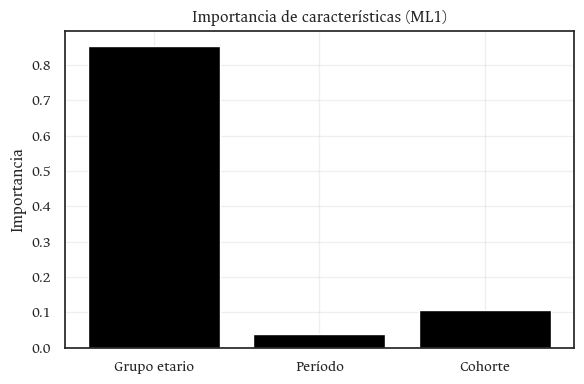

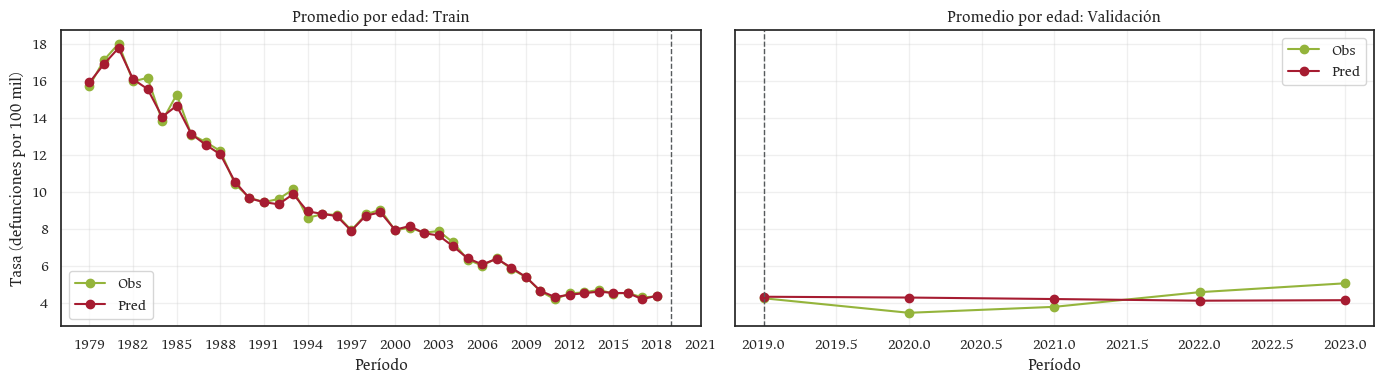

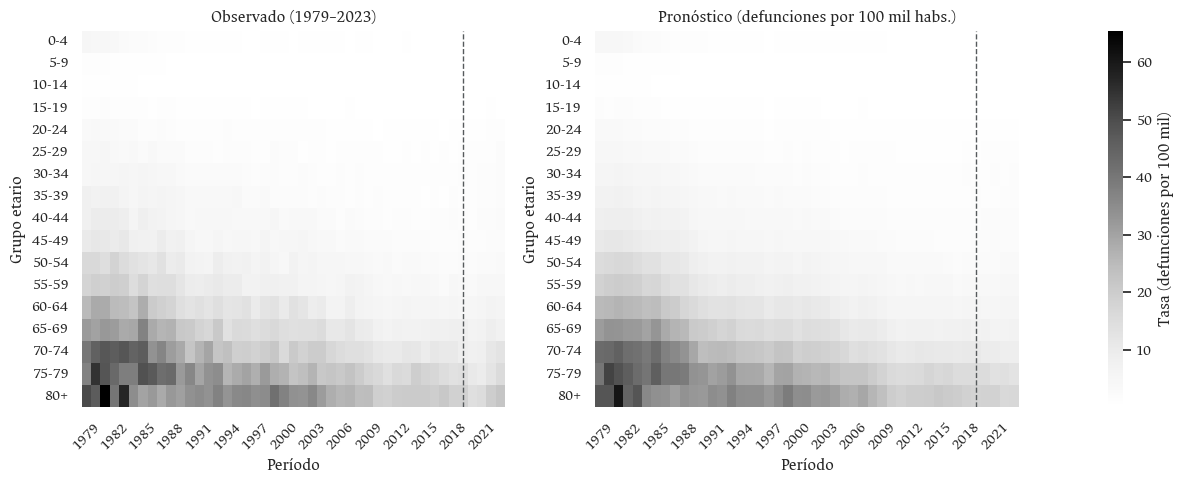

In [41]:
# Gráficos: importancias, líneas agregadas y matrices Obs vs Pred (paleta corporativa y línea 2019)
from viz.style import get_palette, get_sequential_cmap

# Colores corporativos
pal = get_palette(5)
color_obs = pal[0]      # verde corporativo (observado)
color_pred = pal[1]     # rojo vino (predicho)
color_vline = pal[4]    # gris para línea 2019

# Ticks deseados: de 3 en 3 (1979, 1982, ..., 2021)
tick_years = np.arange(1979, 2022, 3)

# Etiquetas de grupos etarios (0-4,5-9,...,75-79,80+) según si el índice es 0..16 o 1..17
ages_sorted = np.sort(ages)
if ages_sorted.min() == 0:
    age_labels = [f"{a*5}-{a*5+4}" if a < 16 else "80+" for a in ages_sorted]
else:  # caso 1..17
    age_labels = [f"{(a-1)*5}-{(a-1)*5+4}" if a < 17 else "80+" for a in ages_sorted]

importances = getattr(gbr, "feature_importances_", None)
if importances is not None:
    plt.figure(figsize=(6,4))
    # plt.bar(["age","year","cohort"], importances, color=pal[0])
    plt.bar(["Grupo etario", "Período", "Cohorte"], importances, color="black")
    plt.title("Importancia de características (ML1)")
    plt.ylabel("Importancia")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "importancias_gbr.png"), dpi=200)
    plt.show()

# Líneas: promedio por período con colores corporativos (escala por 100k)
fig, ax = plt.subplots(1,2, figsize=(14,4), sharey=True)
ax[0].plot(df_period_train['period'], df_period_train['obs']*1e5, label='Obs', marker='o', color=color_obs)
ax[0].plot(df_period_train['period'], df_period_train['pred']*1e5, label='Pred', marker='o', color=color_pred)
ax[0].set_title('Promedio por edad: Train')
ax[0].set_xlabel('Período'); ax[0].set_ylabel('Tasa (defunciones por 100 mil)'); ax[0].grid(alpha=0.3); ax[0].legend()
ax[0].axvline(2019, color=color_vline, ls='--', lw=1)
ax[0].set_xticks(tick_years)

ax[1].plot(df_period_val['period'], df_period_val['obs']*1e5, label='Obs', marker='o', color=color_obs)
ax[1].plot(df_period_val['period'], df_period_val['pred']*1e5, label='Pred', marker='o', color=color_pred)
ax[1].set_title('Promedio por edad: Validación')
ax[1].set_xlabel('Período'); ax[1].grid(alpha=0.3); ax[1].legend()
ax[1].axvline(2019, color=color_vline, ls='--', lw=1)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "lineas_obs_vs_pred_100k.png"), dpi=200)
plt.show()

# Matrices: Observado vs Predicho con colormap secuencial corporativo y colorbar compartido (escala por 100k)
mat_pred_full_100k = pd.DataFrame(index=ages, columns=all_periods, dtype=float)
mat_pred_full_100k.loc[:, train_periods] = mat_train_pred_100k.loc[:, train_periods].values
mat_pred_full_100k.loc[:, val_periods] = mat_val_pred_100k.loc[:, val_periods].values

vmin = float(min(mat_obs_100k.values.min(), mat_pred_full_100k.values.min()))
vmax = float(max(mat_obs_100k.values.max(), mat_pred_full_100k.values.max()))

# cmap_seq = get_sequential_cmap(index=0)  # gradiente blanco→color corporativo 0
cmap_seq = 'Greys'

fig = plt.figure(figsize=(12,5))
gs = fig.add_gridspec(1,3, width_ratios=[1,1,0.035])
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1], sharey=ax0)
cax = fig.add_subplot(gs[0,2])

# Heatmaps
sns.heatmap(mat_obs_100k.values, ax=ax0, cmap=cmap_seq, vmin=vmin, vmax=vmax, cbar=False)
ax0.set_title('Observado (1979–2023)')
ax0.set_xlabel('Período'); ax0.set_ylabel('Grupo etario')

hm = sns.heatmap(mat_pred_full_100k.values, ax=ax1, cmap=cmap_seq, vmin=vmin, vmax=vmax, cbar=True, cbar_ax=cax)
ax1.set_title('Pronóstico (defunciones por 100 mil habs.)')
ax1.set_xlabel('Período'); ax1.set_ylabel('Grupo etario')

# Ajustar etiquetas de grupos etarios
ax0.set_yticks(np.arange(len(age_labels)) + 0.5)
ax0.set_yticklabels(age_labels, rotation=0)
ax1.set_yticks(np.arange(len(age_labels)) + 0.5)
ax1.set_yticklabels(age_labels, rotation=0)

# Posiciones de ticks para períodos
all_periods_list = list(all_periods)
pos_ticks = [all_periods_list.index(y) + 0.5 for y in tick_years if y in all_periods_list]
lab_ticks = [str(y) for y in tick_years if y in all_periods_list]
for a in (ax0, ax1):
    a.set_xticks(pos_ticks)
    a.set_xticklabels(lab_ticks, rotation=45)

# Línea punteada en inicio de validación (2019)
idx_2019 = np.where(all_periods == 2019)[0]
if len(idx_2019) > 0:
    xline = idx_2019[0] + 0.5
    ax0.axvline(x=xline, color=color_vline, ls='--', lw=1)
    ax1.axvline(x=xline, color=color_vline, ls='--', lw=1)

# Etiqueta del colorbar (tasa por 100k)
cax.set_ylabel('Tasa (defunciones por 100 mil)')

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "matrices_obs_pred_1979_2023_100k.png"), dpi=200)
plt.show()


In [11]:
importances

array([0.85466692, 0.03884655, 0.10648653])

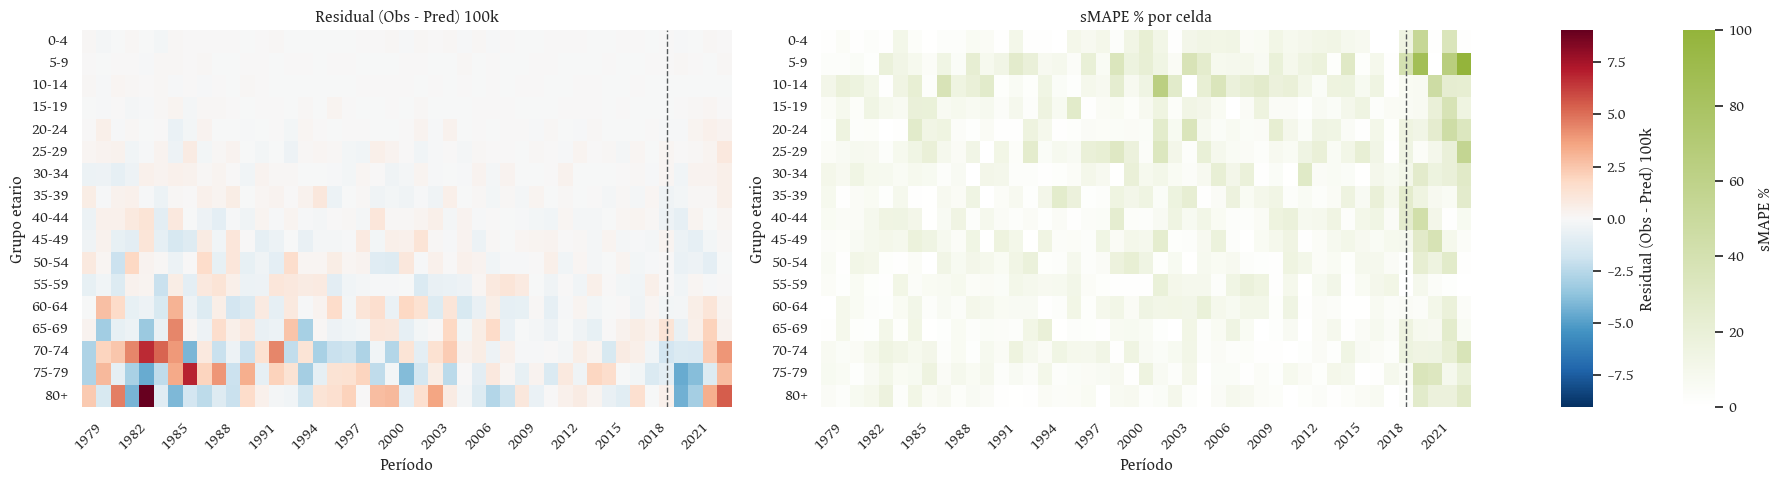

Generados heatmaps de residuales y sMAPE por celda.


In [12]:
# Heatmaps adicionales: Residuales y sMAPE por celda (escala 100k)
EPS_CELL = 1e-12
# Asegurar que la matriz completa predicha exista (en 100k)
mat_pred_full_100k = pd.DataFrame(index=ages, columns=all_periods, dtype=float)
mat_pred_full_100k.loc[:, train_periods] = mat_train_pred_100k.loc[:, train_periods].values
mat_pred_full_100k.loc[:, val_periods] = mat_val_pred_100k.loc[:, val_periods].values

# Residuales (Obs - Pred) y sMAPE por celda
resid_100k = mat_obs_100k.values - mat_pred_full_100k.values
smape_cell = (2 * np.abs(mat_pred_full_100k.values - mat_obs_100k.values) /
              (np.abs(mat_pred_full_100k.values) + np.abs(mat_obs_100k.values) + EPS_CELL)) * 100

# Rangos para color
vmax_res = np.nanmax(np.abs(resid_100k))
vmin_res = -vmax_res
vmin_sm, vmax_sm = 0, min(100, np.nanmax(smape_cell))

cmap_seq = get_sequential_cmap(index=0)

fig = plt.figure(figsize=(18,5))
gs = fig.add_gridspec(1,4, width_ratios=[1,1,0.05,0.05])
ax_r = fig.add_subplot(gs[0,0])
ax_s = fig.add_subplot(gs[0,1], sharey=ax_r)
cax_r = fig.add_subplot(gs[0,2])
cax_s = fig.add_subplot(gs[0,3])

# Residuales
sns.heatmap(resid_100k, ax=ax_r, cmap="RdBu_r", vmin=vmin_res, vmax=vmax_res, cbar=True, cbar_ax=cax_r)
ax_r.set_title("Residual (Obs - Pred) 100k")
ax_r.set_xlabel("Período"); ax_r.set_ylabel("Grupo etario")
# sMAPE
sns.heatmap(smape_cell, ax=ax_s, cmap=cmap_seq, vmin=vmin_sm, vmax=vmax_sm, cbar=True, cbar_ax=cax_s)
ax_s.set_title("sMAPE % por celda")
ax_s.set_xlabel("Período"); ax_s.set_ylabel("Grupo etario")

# Etiquetas de edades
ax_r.set_yticks(np.arange(len(age_labels)) + 0.5)
ax_r.set_yticklabels(age_labels, rotation=0)
ax_s.set_yticks(np.arange(len(age_labels)) + 0.5)
ax_s.set_yticklabels(age_labels, rotation=0)

# Ticks de período cada 3 años
all_periods_list = list(all_periods)
pos_ticks = [all_periods_list.index(y) + 0.5 for y in tick_years if y in all_periods_list]
lab_ticks = [str(y) for y in tick_years if y in all_periods_list]
for a in (ax_r, ax_s):
    a.set_xticks(pos_ticks)
    a.set_xticklabels(lab_ticks, rotation=45)

# Línea 2019
idx_2019 = np.where(all_periods == 2019)[0]
if len(idx_2019) > 0:
    xline = idx_2019[0] + 0.5
    for a in (ax_r, ax_s):
        a.axvline(x=xline, color=color_vline, ls='--', lw=1)

# Etiquetas de colorbar
cax_r.set_ylabel("Residual (Obs - Pred) 100k")
cax_s.set_ylabel("sMAPE %")

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "heatmaps_residual_smape_100k.png"), dpi=200)
plt.show()
print("Generados heatmaps de residuales y sMAPE por celda.")

In [13]:
# Exportar matrices predichas en formato matricial (gr_et × año)
# - Escala por persona (m)
# - Escala por 100k (tasa_x100k)

# Reconstruir matriz completa en escala m (si no existe)
mat_pred_full_m = pd.DataFrame(index=ages, columns=all_periods, dtype=float)
mat_pred_full_m.loc[:, train_periods] = mat_train_pred.loc[:, train_periods].values
mat_pred_full_m.loc[:, val_periods] = mat_val_pred.loc[:, val_periods].values
mat_pred_full_m.index.name = 'gr_et'

# Ya contamos con mat_pred_full_100k (escala x100k)
mat_pred_full_100k.index.name = 'gr_et'

# Exportar (incluye gr_et como primera columna)
out_csv_m = os.path.join(OUT_DIR, 'matriz_pred_m.csv')
out_csv_100k = os.path.join(OUT_DIR, 'matriz_pred_tasa_x100k.csv')

mat_pred_full_m.reset_index().to_csv(out_csv_m, index=False)
mat_pred_full_100k.reset_index().to_csv(out_csv_100k, index=False)

print(f"Escritas matrices predichas:\n- m (por persona): {out_csv_m}\n- tasa_x100k: {out_csv_100k}")

Escritas matrices predichas:
- m (por persona): /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/b_05_ml/matriz_pred_m.csv
- tasa_x100k: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/b_05_ml/matriz_pred_tasa_x100k.csv


In [14]:
# Exportar formato long con valores observados/predichos (100k), error absoluto y relativo
EPS_ERR = 1e-12

# Copias con predicciones en escala m
train_pred_df = train_df.copy()
train_pred_df['pred_m'] = m_train_pred
val_pred_df = val_df.copy()
val_pred_df['pred_m'] = m_val_pred

# Añadir columnas en escala por 100k
for d in (train_pred_df, val_pred_df):
    d['obs_tasa_x100k'] = d['m'] * 1e5
    d['pred_tasa_x100k'] = d['pred_m'] * 1e5
    d['abs_error_100k'] = (d['pred_tasa_x100k'] - d['obs_tasa_x100k']).abs()
    d['rel_abs_error'] = d['abs_error_100k'] / (d['obs_tasa_x100k'].abs() + EPS_ERR)

train_pred_df['dataset'] = 'train'
val_pred_df['dataset'] = 'valid'

cols_out = [
    'dataset','year','age','cohort',
    'obs_tasa_x100k','pred_tasa_x100k','abs_error_100k','rel_abs_error'
]

pred_long = pd.concat([train_pred_df[cols_out], val_pred_df[cols_out]], ignore_index=True)
pred_long = pred_long.sort_values(['dataset','year','age']).reset_index(drop=True)

out_long_csv = os.path.join(OUT_DIR, 'predicciones_long_100k.csv')
pred_long.to_csv(out_long_csv, index=False)
print(f"Exportado formato long con errores a: {out_long_csv}\nFilas: {len(pred_long)}")
print(pred_long.head())

Exportado formato long con errores a: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/b_05_ml/predicciones_long_100k.csv
Filas: 765
  dataset  year  age  cohort  obs_tasa_x100k  pred_tasa_x100k  abs_error_100k  rel_abs_error
0   train  1979    1    1978        4.902391         4.830243        0.072147       0.014717
1   train  1979    2    1977        1.207790         1.178354        0.029436       0.024372
2   train  1979    3    1976        0.910330         0.811869        0.098461       0.108160
3   train  1979    4    1975        1.520229         1.586743        0.066515       0.043753
4   train  1979    5    1974        3.357188         3.295529        0.061659       0.018366


# Optimización de Hiperparámetros y Re-evaluación
En esta sección buscamos mejorar el desempeño del modelo ajustando los hiperparámetros mediante una búsqueda aleatoria (`RandomizedSearchCV`). Utilizamos `TimeSeriesSplit` para la validación cruzada, respetando el orden temporal de los datos. Posteriormente, recalculamos las métricas y regeneramos los gráficos para el modelo optimizado.

In [15]:
# -------------------------------------------------------------------------
# 1. DICCIONARIO DE HIPERPARÁMETROS
# -------------------------------------------------------------------------
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit, GridSearchCV

print("Configurando optimización de hiperparámetros...")

# Definir espacio de búsqueda (Malla robusta)
param_dist = {
    'n_estimators': [500, 800, 1000, 1500, 2000, 3000],
    'learning_rate': [0.005, 0.01, 0.02, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 8, 12],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'max_features': ['sqrt', 'log2', None]
}

# Validación cruzada temporal (3 splits)
tscv = TimeSeriesSplit(n_splits=3)

gbr_search = GradientBoostingRegressor(loss='squared_error', random_state=42)

Configurando optimización de hiperparámetros...


In [16]:
# -------------------------------------------------------------------------
# 2. ENTRENAMIENTO DEL MODELO (BÚSQUEDA ALEATORIA)
# -------------------------------------------------------------------------


# Búsqueda con grilla aleatoria
random_search = RandomizedSearchCV(
    estimator=gbr_search,
    param_distributions=param_dist,
    n_iter=500,
    cv=tscv,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=1,
)

random_search.fit(X_train, y_train)

print(f"Mejores parámetros encontrados: {random_search.best_params_}")
best_model = random_search.best_estimator_

Fitting 3 folds for each of 500 candidates, totalling 1500 fits
Mejores parámetros encontrados: {'subsample': 0.7, 'n_estimators': 500, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 3, 'learning_rate': 0.1}


In [17]:
# -------------------------------------------------------------------------
# 3. CÁLCULO DE PREDICCIONES Y MÉTRICAS
# -------------------------------------------------------------------------
yhat_train_log_opt = best_model.predict(X_train)
yhat_val_log_opt = best_model.predict(X_val)

m_train_pred_opt = np.exp(yhat_train_log_opt)
m_val_pred_opt = np.exp(yhat_val_log_opt)

# Métricas
RMSE_train_opt = np.sqrt(mean_squared_error(m_train_obs, m_train_pred_opt))
MAE_train_opt = mean_absolute_error(m_train_obs, m_train_pred_opt)
sMAPE_train_opt = smape(m_train_obs, m_train_pred_opt)
MAPE_train_opt = np.mean(np.abs((m_train_obs - m_train_pred_opt) / (m_train_obs + 1e-12))) * 100
WAPE_train_opt = wape(m_train_obs, m_train_pred_opt)
RMSE_log_train_opt = np.sqrt(mean_squared_error(y_train, yhat_train_log_opt))
MSE_train_opt = mean_squared_error(m_train_obs, m_train_pred_opt)

RMSE_val_opt = np.sqrt(mean_squared_error(m_val_obs, m_val_pred_opt))
MAE_val_opt = mean_absolute_error(m_val_obs, m_val_pred_opt)
sMAPE_val_opt = smape(m_val_obs, m_val_pred_opt)
MAPE_val_opt = np.mean(np.abs((m_val_obs - m_val_pred_opt) / (m_val_obs + 1e-12))) * 100
WAPE_val_opt = wape(m_val_obs, m_val_pred_opt)
RMSE_log_val_opt = np.sqrt(mean_squared_error(y_val, yhat_val_log_opt))
MSE_val_opt = mean_squared_error(m_val_obs, m_val_pred_opt)

print("\n--- Métricas Modelo Optimizado ---")
print(f"Train | RMSE: {RMSE_train_opt:.4e} | MSE: {MSE_train_opt:.4e} | MAE: {MAE_train_opt:.4e} | MAPE: {MAPE_train_opt:.2f}% | sMAPE: {sMAPE_train_opt:.2f}% | WAPE: {WAPE_train_opt:.2f}%")
print(f"Val   | RMSE: {RMSE_val_opt:.4e} | MSE: {MSE_val_opt:.4e} | MAE: {MAE_val_opt:.4e} | MAPE: {MAPE_val_opt:.2f}% | sMAPE: {sMAPE_val_opt:.2f}% | WAPE: {WAPE_val_opt:.2f}%")

# Preparación de datos para gráficos (reconstrucción de matrices)
mat_train_pred_opt = build_matrix_from_pred(train_df, m_train_pred_opt)
mat_val_pred_opt = build_matrix_from_pred(val_df, m_val_pred_opt)

# Agregados por período
df_period_train_opt = train_df.assign(pred=m_train_pred_opt).groupby("year")[ ["m","pred"] ].mean().reset_index()
df_period_val_opt = val_df.assign(pred=m_val_pred_opt).groupby("year")[ ["m","pred"] ].mean().reset_index()
df_period_train_opt.rename(columns={"year":"period","m":"obs"}, inplace=True)
df_period_val_opt.rename(columns={"year":"period","m":"obs"}, inplace=True)

# Matrices completas (escala 100k)
mat_train_pred_opt_100k = mat_train_pred_opt * 1e5
mat_val_pred_opt_100k = mat_val_pred_opt * 1e5
mat_pred_full_opt_100k = pd.DataFrame(index=ages, columns=all_periods, dtype=float)
mat_pred_full_opt_100k.loc[:, train_periods] = mat_train_pred_opt_100k.loc[:, train_periods].values
mat_pred_full_opt_100k.loc[:, val_periods] = mat_val_pred_opt_100k.loc[:, val_periods].values


--- Métricas Modelo Optimizado ---
Train | RMSE: 1.3448e-05 | MSE: 1.8085e-10 | MAE: 6.6959e-06 | MAPE: 9.53% | sMAPE: 9.38% | WAPE: 7.41%
Val   | RMSE: 1.5077e-05 | MSE: 2.2732e-10 | MAE: 8.1204e-06 | MAPE: 21.69% | sMAPE: 23.20% | WAPE: 19.08%


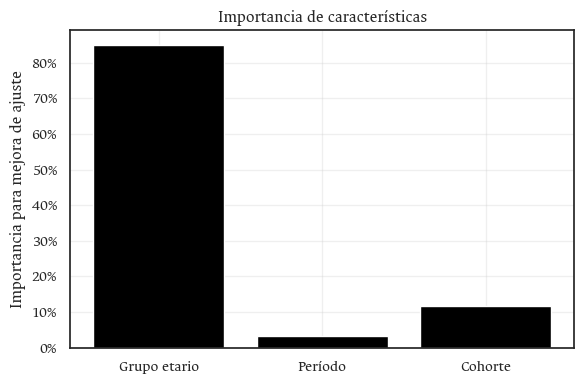

<Figure size 1000x500 with 0 Axes>

In [28]:
# -------------------------------------------------------------------------
# 4. GRÁFICO: IMPORTANCIA DE CARACTERÍSTICAS
# -------------------------------------------------------------------------
importances_opt = getattr(best_model, "feature_importances_", None)
if importances_opt is not None:
    plt.figure(figsize=(6,4))
    plt.bar(["Grupo etario","Período","Cohorte"], importances_opt, color="black")
    plt.title("Importancia de características")
    plt.ylabel("Importancia para mejora de ajuste")
    plt.grid(alpha=0.3)
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}%'.format(y * 100)))
    plt.tight_layout()
    plt.show()

# Guardado del gráfico
plt.savefig(os.path.join(OUT_DIR, "importancias_gbr_optimizado.png"), dpi=200)

In [19]:
importances_opt

array([0.84795504, 0.03418536, 0.11785961])

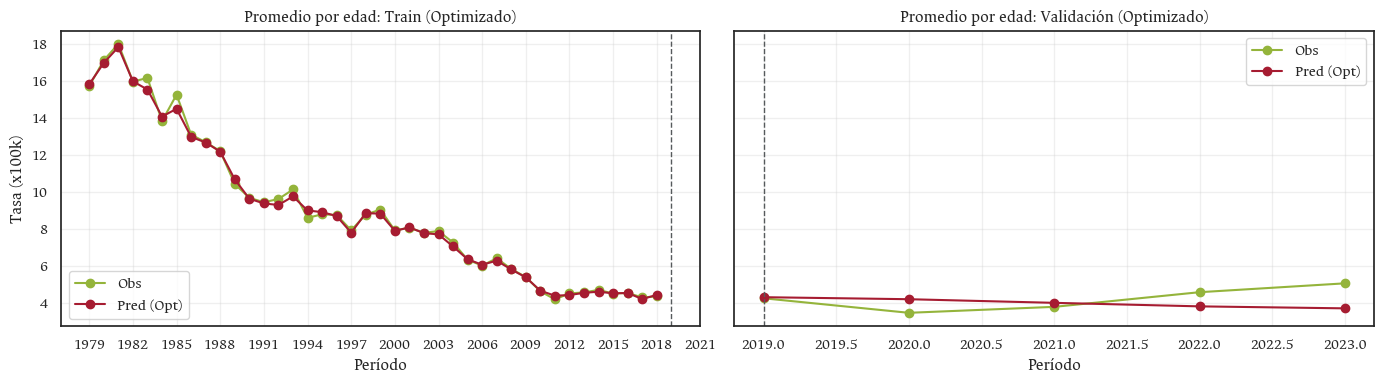

<Figure size 1000x500 with 0 Axes>

In [20]:
# -------------------------------------------------------------------------
# 5. GRÁFICO: LÍNEAS PROMEDIO (OBS vs PRED)
# -------------------------------------------------------------------------
fig, ax = plt.subplots(1,2, figsize=(14,4), sharey=True)
ax[0].plot(df_period_train_opt['period'], df_period_train_opt['obs']*1e5, label='Obs', marker='o', color=color_obs)
ax[0].plot(df_period_train_opt['period'], df_period_train_opt['pred']*1e5, label='Pred (Opt)', marker='o', color=color_pred)
ax[0].set_title('Promedio por edad: Train (Optimizado)')
ax[0].set_xlabel('Período'); ax[0].set_ylabel('Tasa (x100k)'); ax[0].grid(alpha=0.3); ax[0].legend()
ax[0].axvline(2019, color=color_vline, ls='--', lw=1)
ax[0].set_xticks(tick_years)

ax[1].plot(df_period_val_opt['period'], df_period_val_opt['obs']*1e5, label='Obs', marker='o', color=color_obs)
ax[1].plot(df_period_val_opt['period'], df_period_val_opt['pred']*1e5, label='Pred (Opt)', marker='o', color=color_pred)
ax[1].set_title('Promedio por edad: Validación (Optimizado)')
ax[1].set_xlabel('Período'); ax[1].grid(alpha=0.3); ax[1].legend()
ax[1].axvline(2019, color=color_vline, ls='--', lw=1)
plt.tight_layout()
plt.show()

# Guardado del gráfico
plt.savefig(os.path.join(OUT_DIR, "lineas_obs_vs_pred_optimizado_100k.png"), dpi=200)

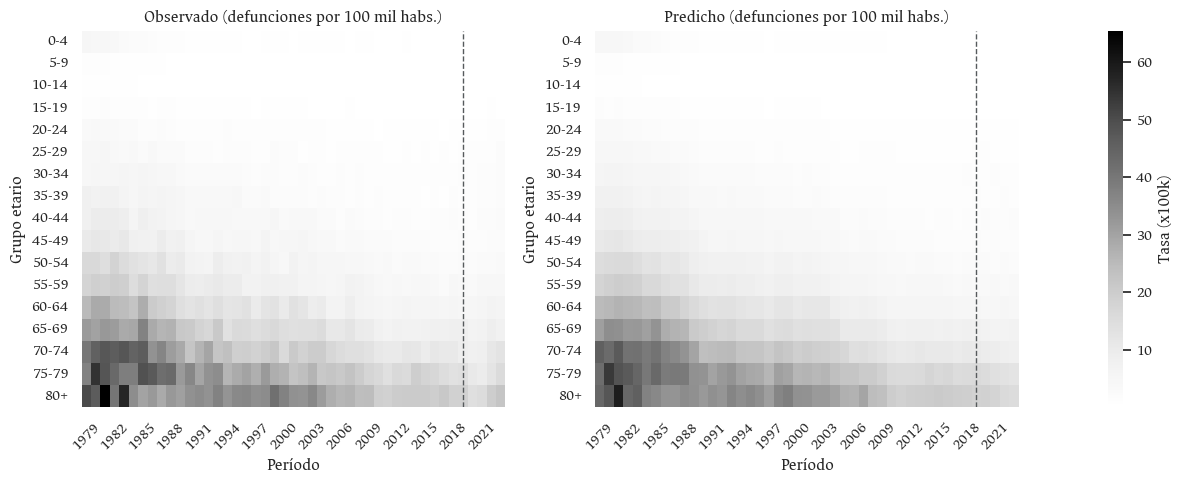

<Figure size 1000x500 with 0 Axes>

In [30]:
# -------------------------------------------------------------------------
# 6. GRÁFICO: HEATMAPS (OBS vs PRED)
# -------------------------------------------------------------------------
vmin = float(min(mat_obs_100k.values.min(), mat_pred_full_opt_100k.values.min()))
vmax = float(max(mat_obs_100k.values.max(), mat_pred_full_opt_100k.values.max()))

fig = plt.figure(figsize=(12,5))
gs = fig.add_gridspec(1,3, width_ratios=[1,1,0.035])
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1], sharey=ax0)
cax = fig.add_subplot(gs[0,2])

sns.heatmap(mat_obs_100k.values, ax=ax0, cmap=cmap_seq, vmin=vmin, vmax=vmax, cbar=False)
ax0.set_title('Observado (defunciones por 100 mil habs.)')
ax0.set_xlabel('Período'); ax0.set_ylabel('Grupo etario')

sns.heatmap(mat_pred_full_opt_100k.values, ax=ax1, cmap=cmap_seq, vmin=vmin, vmax=vmax, cbar=True, cbar_ax=cax)
ax1.set_title('Predicho (defunciones por 100 mil habs.)')
ax1.set_xlabel('Período'); ax1.set_ylabel('Grupo etario')

# Ajustes visuales
for a in (ax0, ax1):
    a.set_yticks(np.arange(len(age_labels)) + 0.5)
    a.set_yticklabels(age_labels, rotation=0)
    a.set_xticks(pos_ticks)
    a.set_xticklabels(lab_ticks, rotation=45)
    a.axvline(x=xline, color=color_vline, ls='--', lw=1)

cax.set_ylabel('Tasa (x100k)')
plt.tight_layout()
plt.show()

# Guardado del gráfico
plt.savefig(os.path.join(OUT_DIR, "matrices_obs_pred_optimizado_100k.png"), dpi=200)

# Interpretabilidad del Modelo (SHAP)
Utilizamos SHAP (SHapley Additive exPlanations) para entender cómo cada característica contribuye a las predicciones del modelo en el conjunto de validación. Analizamos la importancia global y el impacto direccional de cada variable.

In [22]:
# Instalación y carga de SHAP (si no está disponible)
import importlib
try:
    import shap
except ImportError:
    import sys, subprocess
    print("Instalando paquete 'shap'...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "shap"])
    import shap

import numpy as np
import matplotlib.pyplot as plt
import os

print(f"Versión de SHAP: {shap.__version__}")


/Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Versión de SHAP: 0.41.0


In [23]:
# Preparar datos y explainer para GradientBoostingRegressor
# Usamos el modelo optimizado si existe; si no, usamos el modelo base
model_for_shap = best_model if 'best_model' in globals() and best_model is not None else gbr

# SHAP para modelos tipo árbol: TreeExplainer
try:
    explainer = shap.TreeExplainer(model_for_shap)
    is_tree = True
except Exception as e:
    print(f"Fallo TreeExplainer ({e}); usando KernelExplainer (más lento)")
    # Base line con mu de y_train
    background = shap.sample(X_train, 200) if X_train.shape[0] > 200 else X_train
    explainer = shap.KernelExplainer(lambda X: model_for_shap.predict(X), background)
    is_tree = False

# Calculamos SHAP en el conjunto de validación (X_val)
# Para TreeExplainer es rápido; para KernelExplainer limitamos tamaño si es grande
X_val_for_shap = X_val
if not is_tree and X_val.shape[0] > 2000:
    import numpy as np
    idx = np.random.default_rng(42).choice(X_val.shape[0], size=2000, replace=False)
    X_val_for_shap = X_val[idx]
    print(f"Usando subconjunto de validación para SHAP: {X_val_for_shap.shape}")

# Compatibilidad NumPy: alias np.bool requerido por versiones de SHAP
import numpy as np
if not hasattr(np, 'bool'):
    np.bool = np.bool_

shap_values = explainer.shap_values(X_val_for_shap)
shap_values = np.array(shap_values)
print("SHAP calculado.")

# Nombres de características
feature_names = ["age", "year", "cohort"]


SHAP calculado.


In the future `np.bool` will be defined as the corresponding NumPy scalar.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


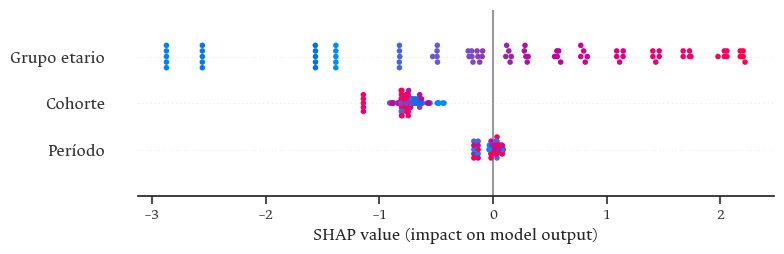

In [ ]:
# Gráficas SHAP: resumen y barras de importancia global
import matplotlib.pyplot as plt
import shap

# Estilo consistente con paleta corporativa
plt.figure(figsize=(8,5))
shap.summary_plot(
    shap_values, 
    X_val_for_shap, 
    #feature_names=feature_names, 
     feature_names=['Grupo etario', 'Período', 'Cohorte'], 
    show=False, 
    color_bar=False, )
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "shap_summary_plot_color.png"), dpi=200)
plt.show()


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


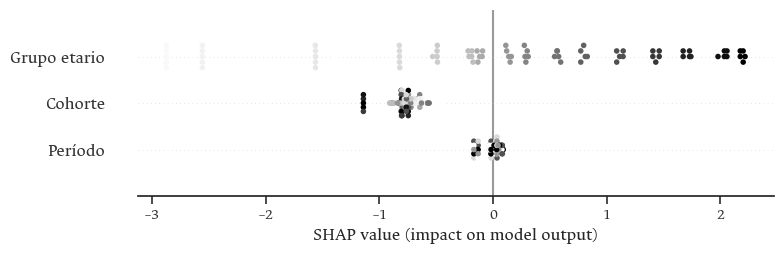

In [ ]:
# Estilo consistente con paleta corporativa
plt.figure(figsize=(8,5))
shap.summary_plot(
    shap_values,
    X_val_for_shap,
    feature_names=['Grupo etario', 'Período', 'Cohorte'],
    cmap='Greys',  # escala de grises
    show=False,
    color_bar=False,
)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "shap_summary_plot_grey.png"), dpi=200)
plt.show()


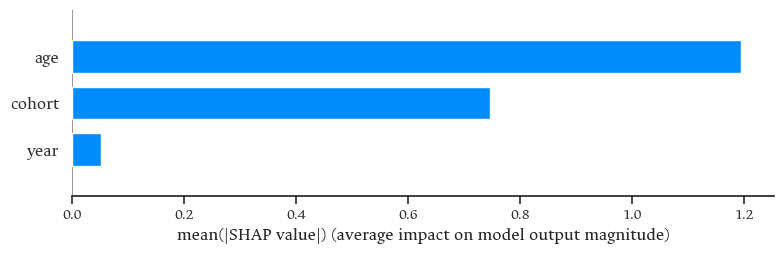

In [25]:
plt.figure(figsize=(8,5))
shap.summary_plot(shap_values, X_val_for_shap, feature_names=feature_names, plot_type='bar', show=False)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "shap_importance_bar.png"), dpi=200)
plt.show()

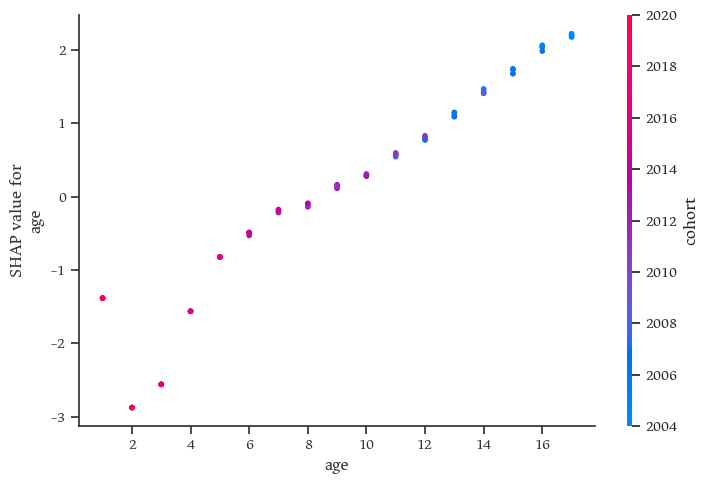

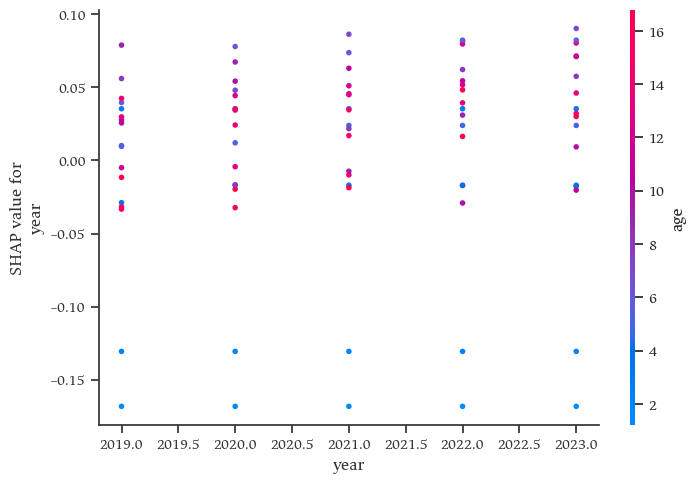

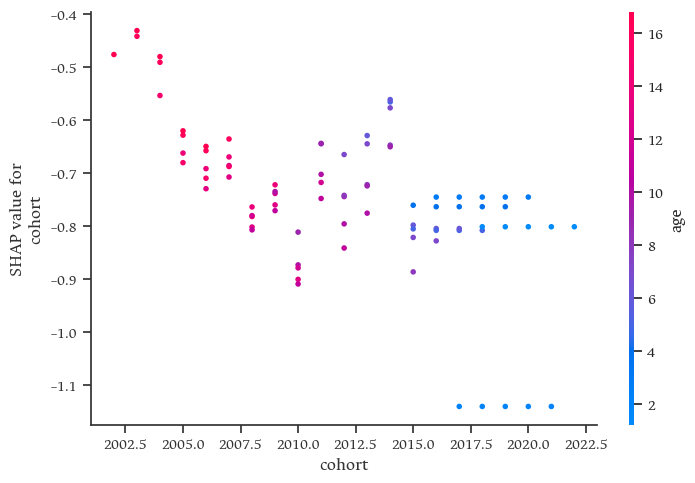

Guardadas gráficas SHAP: summary, bar e independencia por feature.


In [26]:
# Gráficas SHAP de dependencia (uno por característica)
# Shim de compatibilidad para NumPy alias
import numpy as np
if not hasattr(np, 'float'):
    np.float = np.float64

for i, fname in enumerate(feature_names):
    shap.dependence_plot(i, shap_values, X_val_for_shap, feature_names=feature_names, show=False)
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f"shap_dependence_{fname}.png"), dpi=200)
    plt.show()

print("Guardadas gráficas SHAP: summary, bar e independencia por feature.")


Distribución de sesgos (Validación, tolerancia +/- 30%):
sesgo_cat
en rango         63
subestimada      14
sobreestimada     8
Name: count, dtype: int64

Porcentajes:
sesgo_cat
en rango         74.12
subestimada      16.47
sobreestimada     9.41
Name: proportion, dtype: float64




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



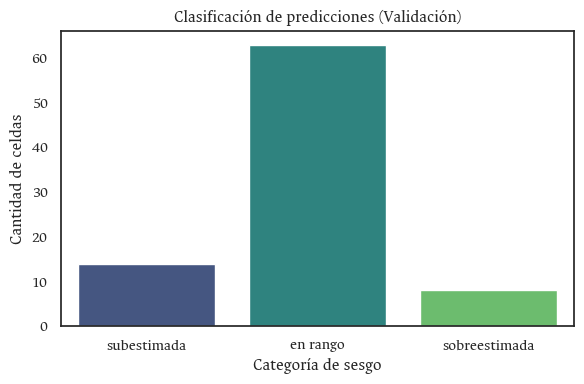

In [27]:
# Análisis de sesgo (Bias) con tolerancia del 30%

# Crear DataFrame con obs y pred (escala 100k)
df_bias = pd.DataFrame({
    'age': X_val[:, 0],
    'year': X_val[:, 1],
    'obs_x100k': m_val_obs * 1e5,
    'pred_x100k': m_val_pred_opt * 1e5
})

# Función de clasificación
def _clasificar_30pct(obs, pred, tol=0.30):
    if pd.isna(obs) or pd.isna(pred):
        return 'missing'
    if obs == 0:
        return 'sobreestimada' if pred > 0 else 'en rango'
    
    ratio = pred / obs
    if ratio > 1.0 + tol:
        return 'sobreestimada'
    elif ratio < 1.0 - tol:
        return 'subestimada'
    else:
        return 'en rango'

# Aplicar clasificación
df_bias['sesgo_cat'] = df_bias.apply(lambda row: _clasificar_30pct(row['obs_x100k'], row['pred_x100k']), axis=1)

# Conteo y porcentajes
bias_counts = df_bias['sesgo_cat'].value_counts()
bias_pct = df_bias['sesgo_cat'].value_counts(normalize=True) * 100

print("Distribución de sesgos (Validación, tolerancia +/- 30%):")
print(bias_counts)
print("\nPorcentajes:")
print(bias_pct.round(2))

# Visualización simple
plt.figure(figsize=(6, 4))
sns.countplot(data=df_bias, x='sesgo_cat', order=['subestimada', 'en rango', 'sobreestimada'], palette='viridis')
plt.title('Clasificación de predicciones (Validación)')
plt.xlabel('Categoría de sesgo')
plt.ylabel('Cantidad de celdas')
plt.tight_layout()
plt.show()